# TERM STRUCTURE COVERAGE USING HULL-WHITE AND EIOPA RISK-FREE CURVE
<a id="0"></a> <br>

The Hull-White model is a very popular choice when modeling interest rates. The simulated risk-free curve is one of the principal inputs into such economic scenario generator. This notebook has 3 sections. The first section uses the EIOPA RFR calibration to produce the yield curve. In the second section, this yield curve is used to produce a number of stochastic scenarios using a HW model. The last section checks how close is the average interest rate from ESG to the term structure provided as input.

### Summary

The goal of this script is to demonstrate a check that verifies if the company is using a sufficienty large number of stochastic scenarios. It also verifies if the term structure used to calibrate the ESG is the same as the one implied in the output.

# Table of Contents  
1. [Note on Smith & Wilson algorithm](#1)
2. [Note on EIOPA RFR curve](#2)
3. [Data requirements](#3)
4. [External dependencies](#4)
5. [Importing data](#5)
6. [Calibration parameters and calibration vector provided by EIOPA](#6)
7. [Smith & Wilson calculation functions](#7)
8. [Hull-White interest rate simulation functions](#8)
9. [Comparison between average ESG output and the assumed term structure](#9)

<a id="1"></a> <br>
## Note on Smith & Wilson algorithm

The calculation of RFR rate was first performed in another script that checks the correct calibration of the EIOPA's RFR output. This example uses a modified Smith&Wilson implementation (The original implementation is availible on [GitHub](https://github.com/open-source-modelling):
-  [Python](https://github.com/open-source-modelling/insurance_python/tree/main/smith%26wilson)
-  [Matlab](https://github.com/open-source-modelling/insurance_matlab/tree/main/smith%26wilson)
-  [JavaScript](https://github.com/open-source-modelling/insurance_javascript/tree/main/smith-wilson)


<a id="2"></a> <br>
## Note on EIOPA RFR curve
The recalculation of the RFR curve from EIOPA's parameters is available on:
-  [Jupyter notebook](https://github.com/qnity/insurance_jupyter/tree/main/enough_stochastic_scenarios)

#### Limitations of the implementation
This script covers a synthetic dataset of ESG scenarios.It also simplifies the day-count convention with the assumption that each month represents 1/12-th of a year. The discretisation and numeric integration uses the simplest Euler scheme and the rectangular rule respectively.

<a id="3"></a> <br>
## Data requirements

This script contains the EIOPA risk-free rate publication for March 2023. The publication can be found on the [EIOPA RFR website](https://www.eiopa.europa.eu/tools-and-data/risk-free-interest-rate-term-structures_en).

The observed maturities `m_obs` and the calibrated vector `Qb` can be found in the Excel sheet *EIOPA_RFR_20230331_Qb_SW.xlsx*.

For this example, the curve without the volatility adjustment (VA) is used. It can be found in the sheet *SW_Qb_no_VA*. This example is focused on the EUR curve, but this example can be easily modified for any other curve.

The target maturities (`t_obs`), the additional parameters (`UFR` and `alpha`), and the given curve can be found in the Excel *EIOPA_RFR_20230331_Term_Structures.xlsx*. Sheet *RFR_spot_no_VA* if the test looks at the curve without the Volatility Adjustment and the sheet *RFR_spot_with_VA* if the test looks at the curve with the Volatility Adjustment.

Some example parameters for the Hull-White model are used:

In [1]:
NoOfPaths = 400 # Number of stochastic scenarios
NoOfSteps = 100 # Number of equidistand discrete modelling points ( 50*12 = 600)
T = 50.0        # Time horizon in years
lambd = 0.02    # Hull-White parameter lambda
sigma = 0.01    # Hull-White volatility parameter sigma
epsilon = 0.1   # Incremental distance used to calculate for numerical approximation
                # of for example the instantaneous spot rate

[Back to the top](#0)
<a id="4"></a> <br>
         
## External dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[Back to the top](#0)
<a id="5"></a> <br>
## Importing data

In [3]:
selected_param_file = 'Param_no_VA.csv'
selected_curves_file = 'Curves_no_VA.csv'

In [4]:
param_raw = pd.read_csv(selected_param_file, sep=',', index_col=0)

The country selected is:

In [5]:
country = "Slovenia"

In [6]:
maturities_country_raw = param_raw.loc[:,country+"_Maturities"].iloc[6:]
param_country_raw = param_raw.loc[:,country + "_Values"].iloc[6:]
extra_param = param_raw.loc[:,country + "_Values"].iloc[:6]

In [7]:
relevant_positions = pd.notna(maturities_country_raw.values)

In [8]:
maturities_country = maturities_country_raw.iloc[relevant_positions]

In [9]:
Qb = param_country_raw.iloc[relevant_positions]

In [10]:
curve_raw = pd.read_csv(selected_curves_file, sep=',',index_col=0)

In [11]:
curve_country = curve_raw.loc[:,country]

[Back to the top](#0)
<a id="6"></a> <br>
## Calibration parameters and calibration vector provided by EIOPA

In [12]:
# Maturity of observations:
m_obs = np.transpose(np.array(maturities_country.values))

# Ultimate froward rate ufr represents the rate to which the rate curve will 
# converge as time increases:
ufr = extra_param.iloc[3]/100

# Convergence speed parameter alpha controls the speed at which the curve 
# converges towards the ufr from the last liquid point:
alpha = extra_param.iloc[4]

# For which maturities do we want the SW algorithm to calculate the rates. 
# In this case, for every year up to 150:
M_Target = np.transpose(np.arange(1,151)) 

# Qb calibration vector published by EIOPA for the curve calibration:
Qb = np.transpose(np.array(Qb.values))

[Back to the top](#0)
<a id="7"></a> <br>
## Smith & Wilson calculation functions

In this step, an independent version of the Smith&Wilson algorithm is implemented. To do this, two functions are taken from the publicly available repository and modified to accept the product of `Q*b` instead of the calibration vector `b`.

In [13]:
def sw_extrapolate(m_target, m_obs, Qb, ufr, alpha, epsilon = 0.00001):
    """
    Interpolate or extrapolate rates for targeted maturities using a 
    Smith-Wilson algorithm.
       sw_extrapolate(m_target, m_obs, Qb, ufr, alpha) calculates the rates for 
           maturities specified in M_Target using the calibration vector b.
    Args:
        m_target (ndarray): k x 1 array of targeted bond maturities.
        m_obs (ndarray): n x 1 array of observed bond maturities.
        Qb (ndarray): n x 1 array. Calibration vector calculated on bonds.
        ufr (float): Ultimate forward rate.
        alpha (float): Convergence speed parameter.
        epsilon (float): Increment to calculate the instantaneous spot rate.

    Returns:
        ndarray: k x 1 array of targeted rates for zero-coupon bonds with 
            maturity from m_target.

    For more information see 
    https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate
        /12092019-technical_documentation.pdf
    """
    
    def sw_heart(u, v, alpha):
        """
        Calculate the heart of the Wilson function. sw_heart(u, v, alpha) 
        calculates the matrix H (Heart of the Wilson function) for maturities 
        specified by vectors u and v. The formula is taken from the EIOPA technical 
        specifications paragraph 132.

        Args:
            u (ndarray): n_1 x 1 vector of maturities.
            v (ndarray): n_2 x 1 vector of maturities.
            alpha (float): Convergence speed parameter.

        Returns:
            ndarray: n_1 x n_2 matrix representing the Heart of the Wilson function.
        """
        u_mat = np.tile(u, [v.size, 1]).transpose()
        v_mat = np.tile(v, [u.size, 1])
        return 0.5 * (alpha * (u_mat + v_mat) + np.exp(-alpha * (u_mat + v_mat)) 
                      - alpha * np.absolute(u_mat - v_mat) - 
                      np.exp(-alpha * np.absolute(u_mat - v_mat)))
    
    # Heart of the Wilson function from paragraph 132
    h = sw_heart(m_target, m_obs, alpha) 
    
    # Discount pricing function for targeted maturities from paragraph 147
    p = np.exp(-np.log(1 + ufr) * m_target) + np.diag(np.exp(-np.log(1 + ufr) 
                                                     * m_target)) @ h @ Qb 
    
    # If the first element of m_target is zero, replace it with time "epsilon" 
    # to avoid division by zero error.
    m_target[0] = epsilon if m_target[0] == 0 else m_target[0]

    return p ** (-1 / m_target) - 1

[Back to the top](#0)
<a id="8"></a> <br>
## Hull-White interest rate simulation functions

In this step, the functions that calculate the necessary Hull-White outputs are defined. The calculation of a discounted ZCB bond, calculation of a forward rate, the parameter theta and finally the generation of multiple sample paths.

The function P0t_f calculates the price of a zero-coupon bond (ZCB) based on the given yield and maturity.

$$ P0t = e^{-y0t *t} $$

Where:
 - `t` is the time of interest expressed as a year fraction (Ex. for 18 months, `t` = 1.5).
 - `y0t` is the yield obtained by applying the Smith-Wilson calibration to the term structure 
     for a single payoff at time `t`.
 -  `P0t` is the price of a zero coupon bond with a notional amount of 1 and maturity at time `t`.

In [14]:
def P0t_f(t, m_obs, Qb, ufr, alpha):
    """
    P0t_f function calculates the price of a zero-coupon bond issued at time 0, 
    for a given maturity 't', using the Smith-Wilson extrapolation technique.
    Args:
        t (float or ndarray): vector (or a single number) of maturities represented 
            as time fraction (Ex. for 18 months; t=1.5).
        m_obs (ndarray): n x 1 array of observed bond maturities used for 
            calibration.
        Qb (ndarray): n x 1 calibration vector of the Smith-Wilson algorithm 
           calculated on observed bonds.
        ufr (float): Ultimate forward rate parameter for the Smith-Wilson algorithm.
        alpha (float): Convergence speed parameter for the Smith-Wilson algorithm.
    Returns:
        ndarray: n x 1 the price of zero-coupon bonds with a notional amount of 1
            and maturity t.   
        
    Example of use
        m_obs = np.array([1, 2, 3, 5, 7, 10, 15, 20, 30])
        Qb = np.array([0.02474805, 0.02763133, 0.02926931, 0.0302894, 0.03061605,
           0.03068016, 0.03038397, 0.02999401, 0.02926168])
        ufr = 0.042
        alpha = 0.05        

        # For a single maturity
        t = 5
        price = P0t_f(t, m_obs, Qb, ufr, alpha)
        print(f"Price of zero-coupon bond with maturity {t} years is: {price}")

        # For multiple maturities
        t = [1, 3, 5, 10]
        prices = P0t_f(t, m_obs, Qb, ufr, alpha)
        print("Prices of zero-coupon bonds with maturities", t, "years are:")
        print(prices)

    Implemented by Gregor Fabjan from Open-Source Modelling on 29/07/2023
    """

    if isinstance(t, np.ndarray): # If the input is a numpy array
        y0t = sw_extrapolate(np.transpose(t), m_obs, Qb, ufr, alpha)
        out = np.exp(-y0t*np.transpose(t)) 
    else:# If the input is a single maturity given as a number
        y0t = sw_extrapolate(np.transpose([t]), m_obs, Qb, ufr, alpha)
        out = np.exp(-y0t*[t]) 
    return out

The function f0t calculates the instantaneous forward rate at time `t` using a numerical approximation with a step size given by the parameter `epsilon`. The calculation of the instantaneous forward rate relies on the difference between two zero-coupon bond prices. One maturing at time $t +\epsilon $ and another at time $t - \epsilon $. 



The centered finite difference method estimates the instantaneous forward rate using the following approximation:

$$ f(0,t) \approx -\frac{\log(P(0, t+\epsilon)) - \log(P(0, t-\epsilon)) }{2 \epsilon}  $$

In [15]:
def f0t(t, P0t, epsilon):
    """
    Calculates the instantaneous forward rate for time t given the zero-coupon
    bond price function P0t, using the centered finite difference method.

    Args:
        t (float): Time at which the instantaneous forward rate is calculated.
        P0t (function): Function that takes a float argument `t` and 
            returns the price of a zero-coupon bond with maturity `t` and
            notional amount 1.
        epsilon (float): Step size for the centered finite difference method.

    Returns:
        float: The instantaneous forward rate at time t, calculated using the 
            centered finite difference method.
    """
    
    p_plus = P0t(t + epsilon)
    p_minus = P0t(t - epsilon)
    return -(np.log(p_plus) - np.log(p_minus)) / (2 * epsilon)

The function HW_theta calculates the time depened $\theta$. In this implementation, this parameter is calibrated to the term stucture obtained using the EIOPA RFR. The term structure is specified by the P0t function that is passed as argument.

The parameter `theta` is calibrated using the following relation:

$$ \theta(t) =  \frac{1}{\lambda} \frac{\partial f(0,t)}{\partial t} + f(0,t) + \frac{\sigma^2}{2 \lambda^2}\big( 1 - e^{-2 \lambda t} \big)    $$

Where:
 - `t` is the time at which we wish to calibrate $\theta$ to the term structure. (Ex. 18 months means t = 1.5).
 - $\lambda$ is the $ \lambda$ parameter in the Hull-White model.
 - $\sigma$ is the volatility parameter $ \sigma$ of the Hull-White model.
 - $f(0,t)$ is the instantaneous forward rate at time `t` estimated at time 0.
 - $\theta(t)$ is the time dependet parameter $\theta$ of the Hull-White model.

In [16]:
def HW_theta(lambd, sigma, P0t, eps):
    """
    Calculates the theta value for the Hull-White model 
    using a numeric approximation of the instantaneous forward rate 
    and the spot rate.

    Args:
        lambd (float): mean reversion rate parameter lambda.
        sigma (float): volatility parameter sigma.
        P0t (function handle): function that calculates the price of a
            zero-coupon bond as a function of time.
        eps (float): increment of time used in the numeric calculation of the 
            derivative of the instantaneous forward rate.

    Returns:
        theta (function): function that returns the parameter theta of 
            Hull-White model at the time t.
    """
    
    def theta(t):
        insta_forward_term = 1.0/lambd *(f0t(t+eps, P0t, eps) 
                                         -f0t(t-eps,P0t,eps))/(2.0*eps)
                                         
        forward_term = f0t(t, P0t, eps)
        variance_term = sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
        return insta_forward_term + forward_term + variance_term
    return theta

In [17]:
def Paths(NoOfPaths, NoOfSteps, T, P0t, lambd, sigma, epsilon):
    """
    Simulates a series of stochastic interest rate paths using the Hull-White model.

    Args:
        NoOfPaths (int): number of paths to simulate.
        NoOfSteps (int): number of time steps per path.
        T (float): end of the modelling window (in years). 
            (Ex. a modelling window of 50 years means T=50).
        P0t (function): function that calculates the price of a 
            zero coupon bond issued at time 0 that matures at time t, with a
            notional amount 1 and discounted using the assumed term structure.
        lambd (float): mean reversion speed parameter lambda of 
            the Hull-White model.
        sigma (float): volatility parameter sigma of the Hull-White model.
        epsilon (float): size of the increment used for finite 
            difference approximation.

    Returns:
        dict: A dictionary containing arrays with time steps, interest rate paths, 
            and bond prices.
            time (array): array of time steps.
            R (array): array of interest rate paths with 
              shape (NoOfPaths, NoOfSteps+1).
            M (array): array of bond prices with 
              shape (NoOfPaths, NoOfSteps+1).

    Implemented by Gregor Fabjan from Open-Source Modelling on 29/07/2023.

    Original inspiration: https://www.youtube.com/watch?v=BIZdwUDbnDo
    """       
    
    # Initial instantaneous forward rate at time t-> 0 (also spot rate at time 0).
    # r(0) = f(0,0) = - partial derivative of log(P_mkt(0, epsilon) w.r.t epsilon)
    r0 = f0t(epsilon, P0t, epsilon)
    
    # Calculation of theta = 1/lambda * partial derivative of f(0,t) w.r.t. t 
    # + f(0,t) + sigma^2/(2 lambda^2)* (1-exp(-2*lambda*t))
    theta = HW_theta(lambd, sigma, P0t, epsilon)
    
    # Generate the single source of random noise
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])

    # Initialize arrays
    
    # Vector of time moments. Difference between two time moments is equal 
    # to the time increment 
    time = np.linspace(0, T, NoOfSteps+1) 
    
    # Initialize vector with interest rate increments
    R = np.zeros([NoOfPaths, NoOfSteps+1]) 
    
    # First interest rate equals the instantaneous forward (spot) 
    # rate at time 0.
    R[:, 0] = r0 
    dt = T/float(NoOfSteps) # size of increments between two steps
    
    for iTime in range(1, NoOfSteps+1): # For each time increment
        # Making sure the samples from the normal distribution have a mean of 0 
        # and variance 1
        if NoOfPaths > 1:
            Z[:,iTime-1] = (Z[:,iTime-1]-np.mean(Z[:,iTime-1]))/np.std(Z[:,iTime-1])
        # apply the Euler-Maruyama discretisation scheme for the Hull-White model
        # at each time increment
        noise_term = sigma*np.power(dt,0.5)*Z[:, iTime-1]
        rate_term = lambd*(theta(time[iTime-1])-R[:,iTime-1])*dt
        R[:,iTime] = R[:,iTime-1] + rate_term + noise_term
    
    # Vectorized numeric integration using the Euler integration method 
    M = np.exp(0.5 * (R[:, :-1] + R[:, 1:]) * dt) 
    M = np.insert(M, 0, 1, axis=1).cumprod(axis=1)
    
    # Output is a dataframe with time moment, the interest rate path and the price
    # of a zero coupon bond issued at time 0 that matures at the selected time 
    # moment with a notional value of 1
    paths = {"time":time, "R":R, "M":M}
    return paths

[Back to the top](#0)
<a id="9"></a> <br>
## Comparison between average ESG output and the assumed term structure 

In this final section, the ESG output is generated and visualy compared to the assumed term structure.

In [18]:
def mainCalculation(NoOfPaths, NoOfSteps, T, lambd, sigma, P0t, epsilon):
    """
    Calculates and plots the prices of zero-coupon bonds (ZCB) calculated 
    using the Hull-White model`s analytical formula and the Monte Carlo simulation.
    
    Args:
        NoOfPaths (int): number of Monte Carlo simulation paths.
        NoOfSteps (int): number of time steps per path.
        T (float): length in years of the modelling window (Ex. 50 years means t=50).
        lambd (float): mean reversion rate parameter lambda of the Hull-White model.
        sigma (float): volatility parameter sigma of the Hull-White model.
        P0t (function): function that calculates the price of a zero coupon bond issued. 
           at time 0 that matures at time t, with a notional amount 1 and discounted using
           the assumed term structure.
        epsilon (float): the size of the increment  used for finite difference approximation.
    
    Returns:
        Nothing.
    """
 
    paths = Paths(NoOfPaths, NoOfSteps, T, P0t, lambd, sigma, epsilon)
    M = paths["M"]
    t = paths["time"]
    
    # Compare the price of an option on a ZCB from Monte Carlo and the analytical expression
    P = np.zeros([NoOfSteps+1])
    for i in range(0, NoOfSteps+1):
        P[i] = np.mean(1.0/M[:, i])
    plt.figure(1)
    plt.grid()
    plt.xlabel("t")
    plt.ylabel("P(0,t)")
    plt.plot(t,P0t(t))
    plt.plot(t,P,"--r")
    plt.legend(["P(0,t) market", "P(0,t) Monte Carlo"])
    plt.title("ZCBs from Hull-White model")

In [19]:
# Zero coupon bond prices calculated using the assumed term structure
P0t = lambda t: P0t_f(t, m_obs, Qb, ufr, alpha)

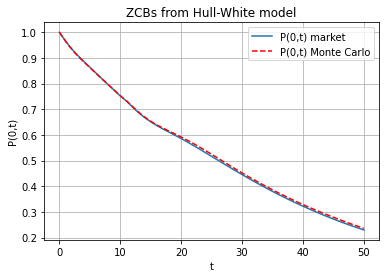

In [20]:
# Final comparison
mainCalculation(NoOfPaths, NoOfSteps, T, lambd, sigma, P0t, epsilon)